# Objectives

The aim is to predict cities most impacted by fatal police shootings in the USA.

# Dataset

__Source of fatal police shootings__ :
* between 2015 & 2017 : https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us
* between 2000 & 2016 : https://data.world/awram/us-police-involved-fatalities

__Source of data on poverty rate, high school graduation rate, median household income, racial demographics and total population__ : https://www.census.gov/

# Libraries

In [2]:
import numpy as np
import pandas as pd

In [3]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.colors as mcolors

In [5]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [6]:
from functools import partial
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_tweedie_deviance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, auc
from sklearn.metrics import mean_squared_log_error
from sklearn.dummy import DummyRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Data cleaning

The goal in this first part is :
* to join the 2 datasets of fatal police shootings on the same columns
* to clean the resulting dataframe
* to drop duplicates rows given that some data can complete each other from the 2 datasets.

In [7]:
df_new=pd.read_csv('data/PoliceKillingsUS_2015_2017.csv', encoding = "ISO-8859-1")

In [8]:
df_new

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,2822,Rodney E. Jacobs,28/07/17,shot,gun,31.0,M,NaN,Kansas City,MO,False,attack,Not fleeing,False
2531,2813,TK TK,28/07/17,shot,vehicle,NaN,M,NaN,Albuquerque,NM,False,attack,Car,False
2532,2818,Dennis W. Robinson,29/07/17,shot,gun,48.0,M,NaN,Melba,ID,False,attack,Car,False
2533,2817,Isaiah Tucker,31/07/17,shot,vehicle,28.0,M,B,Oshkosh,WI,False,attack,Car,True


In [9]:
df_old=pd.read_csv('data/awram-us-police-involved-fatalities2000_2015/Police Fatalities.csv', encoding = "ISO-8859-1")

In [10]:
df_old

,UID,Name,Age,Gender,Race,Date,City,State,Manner_of_death,Armed,Mental_illness,Flee
0,133,Karen O. Chin,44.0,Female,Asian,5/4/2000,Alameda,CA,Shot,NaN,False,False
1,169,Chyraphone Komvongsa,26.0,Male,Asian,6/2/2000,Fresno,CA,Shot,NaN,False,False
2,257,Ming Chinh Ly,36.0,Male,Asian,8/13/2000,Rosemead,CA,Shot,Gun,False,False
3,483,Kinh Quoc Dao,29.0,Male,Asian,2/9/2001,Valley Glen,CA,Shot,Gun,False,False
4,655,Vanpaseuth Phaisouphanh,25.0,Male,Asian,6/10/2001,Riverside,CA,Shot,Knife,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
12486,12388,Name withheld by police,NaN,Male,NaN,12/9/2008,Sacramento,CA,Other,NaN,False,False
12487,12429,Gene Lovell Ford,48.0,Male,NaN,8/6/2008,Sacramento,CA,Other,NaN,True,False
12488,12430,Jose Vega,38.0,Male,NaN,8/6/2008,Visalia,CA,Other,NaN,True,False
12489,12636,Humberto Torres,41.0,Male,NaN,3/21/2009,Delano,CA,Other,Gun,False,False


In [11]:
df_new.threat_level.value_counts(normalize=True)

attack          0.635503
other           0.302170
undetermined    0.062327
Name: threat_level, dtype: float64

Only two columns are different between the two datasets. There is no 'threat_level' and no 'body_camera' in the second one. As the first didn't provide relevant value (we don't know anything for 1/3 of the data), I can drop this column. Same for the second.

In [12]:
df_new.drop(['id', 'threat_level', 'body_camera' ], axis=1, inplace=True) 

In [13]:
df_old.drop('UID', axis=1, inplace=True)

In [14]:
# different format of date in the 2 dataframe
df_new['date'] = pd.to_datetime(df_new['date'], dayfirst=True)
df_old['Date'] = pd.to_datetime(df_old['Date'])

In [15]:
df_old.columns=[i.lower() for i in df_old.columns]

In [16]:
[i for i in df_old.columns if i not in df_new.columns]

['mental_illness']

In [17]:
df_old['signs_of_mental_illness']=df_old['mental_illness']
df_old.drop('mental_illness', axis=1, inplace=True)

In [18]:
#the name of columns of the 2 df are the same, they can be merged
df = df_new.append(df_old)

In [19]:
df.head()

,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,flee
0,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,Not fleeing
1,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,Not fleeing
2,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,Not fleeing
3,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,Not fleeing
4,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,Not fleeing


Now check columns one by one to clean and unify them

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15026 entries, 0 to 12490
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   name                     15026 non-null  object        
 1   date                     15026 non-null  datetime64[ns]
 2   manner_of_death          15026 non-null  object        
 3   armed                    9340 non-null   object        
 4   age                      14716 non-null  float64       
 5   gender                   15018 non-null  object        
 6   race                     10866 non-null  object        
 7   city                     15022 non-null  object        
 8   state                    15026 non-null  object        
 9   signs_of_mental_illness  15026 non-null  bool          
 10  flee                     14961 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(1), object(8)
memory usage: 1.3+ MB


In [21]:
df.drop_duplicates(inplace=True)

In [22]:
df.name=df.name.replace('Name withheld by police', 'unknown').replace('TK TK', 'unknown')
df.manner_of_death=np.where(df.manner_of_death=='shot', 'Shot', df.manner_of_death)
df.manner_of_death=np.where(df.manner_of_death=='shot and Tasered', 'Shot and Tasered', df.manner_of_death)

In [23]:
df['armed'] = df['armed'].str.lower()
df['city'] = df['city'].str.lower()
df.armed=np.where(df.armed=='axe', 'ax', df.armed)
df.armed=np.where(df.armed=='motorcycle', 'vehicle', df.armed)
df.armed=df.armed.replace('undetermined', 'unknown')
df.armed=df.armed.fillna('unknown')
df.gender=np.where(df.gender=='Female','F',df.gender)
df.gender=np.where(df.gender=='Male','M',df.gender)
df.race=np.where(df.race=='A', 'Asian', df.race)
df.race=np.where(df.race=='B', 'Black', df.race)
df.race=np.where(df.race=='H', 'Hispanic', df.race)
df.race=np.where(df.race=='O', 'Other', df.race)
df.race=np.where(df.race=='N', 'Native', df.race)
df.race=np.where(df.race=='W', 'White', df.race)
df = df.drop(df[df['city'].isna()].index).reset_index(drop=True)
dic={False:0, True:1, 'Not fleeing':0,'Car':1, 'Foot':1,'Other':'unknown'}

df.signs_of_mental_illness=df.signs_of_mental_illness.map(dic)
df.flee=df.flee.map(dic)
df.drop_duplicates(inplace=True)
df['test_drop']=""
df=df.sort_values(by='name').reset_index(drop=True)

In [24]:
#function to complete rows if there are duplicated partially and they complete themself
for i in range(df.shape[0]-1):
    if (df.iloc[i,0]==df.iloc[i+1,0]) & (df.iloc[i,1]==df.iloc[i+1,1]) & (df.iloc[i,9]==df.iloc[i+1,9]):
        for c in range(df.shape[1]):
            if (df.iloc[i,c]=='unknown') | (pd.isna(df.iloc[i, c])):
                df.iloc[i,c]=df.iloc[i+1,c]
        df.iloc[i+1, 11]=i

In [25]:
for i in range(df.shape[0]-1):
    if (df.iloc[i,0]==df.iloc[i+1,0]) & (df.iloc[i,1]==df.iloc[i+1,1]) & (df.iloc[i,9]==df.iloc[i+1,9]):
        for c in range(df.shape[1]):
            if (df.iloc[i,c]=='unknown') | (pd.isna(df.iloc[i, c])):
                df.iloc[i,c]=df.iloc[i+1,c]
        df.iloc[i+1, 11]='drop'

In [26]:
df = df.drop(df[df['test_drop']=='drop'].index).reset_index(drop=True)
df.drop('test_drop', axis=1, inplace=True)

In [27]:
#check how many values are missing for every rows
df['rdrop']=""
for i in range(df.shape[0]):
    k=0
    for c in range(df.shape[1]-1):
        if (df.iloc[i,c]=='unknown')|(pd.isna(df.iloc[i, c]))|(df.iloc[i,c]=='Other'):
            k+=1
    df.iloc[i,11]=k
    
#drop 192 rows with 3 or more missing values 
df = df.drop(df[df.rdrop>2].index).reset_index(drop=True)
df.drop('rdrop', axis=1, inplace=True)

# Additional data on poverty rate, high school graduation rate, median household income, and racial demographics

The goal here is to add data about the city. 

The final objective is to create a dataframe which gives per city :
* the number of people killed by the police, 
* informations about the city : 
    * size of the population, 
    * poverty, 
    * wealth, 
    * education, 
    * share between etnic groups

In [28]:
df_medianincome=pd.read_csv('data/MedianHouseholdIncome2015.csv', encoding = "ISO-8859-1")
df_poverty=pd.read_csv('data/PercentagePeopleBelowPovertyLevel.csv', encoding = "ISO-8859-1")
df_eduction=pd.read_csv('data/PercentOver25CompletedHighSchool.csv', encoding = "ISO-8859-1")
df_ShareRaceByCity=pd.read_csv('data/ShareRaceByCity.csv')
df_ShareRaceByCity.columns=['Geographic Area', 'City', 'share_white', 'share_black',
       'share_native_american', 'share_asian', 'share_hispanic']
df_city = pd.merge(df_medianincome, df_poverty, on=['City','Geographic Area'])
df_city = pd.merge(df_city, df_eduction, on=['City','Geographic Area'])
df_city = pd.merge(df_city, df_ShareRaceByCity, on=['City','Geographic Area'])
df_city['City'] = df_city['City'].str.lower()
df_city.columns=['state', 'city', 'Median Income', 'poverty_rate',
       'percent_completed_hs', 'share_white', 'share_black',
       'share_native_american', 'share_asian', 'share_hispanic']
df_city['city']=df_city['city'].str.replace(' city','')
df_city['city']=df_city['city'].str.replace(' \(balance\)','')
df_city['city']=df_city['city'].str.replace('louisville/jefferson county metro government','louisville')
df_city['city']=df_city['city'].str.replace('nashville-davidson metropolitan government','nashville')
df_city['city']=df_city['city'].str.strip(' ')
df_city['city']=df_city['city'].str.replace('urban honolulu cdp','honolulu')
df_city['city']=df_city['city'].str.replace('lexington-fayette urban county','lexington')

In [29]:
#retrieve data about population size in the cities
df_pop=pd.read_csv('data/pop_cities2019_all.csv')
df_pop = df_pop.drop(df_pop[df_pop.NAME==df_pop.STNAME].index).reset_index(drop=True)
df_pop=df_pop[['NAME','STNAME','POPESTIMATE2017']]
df_pop.columns=['city','state_name','population']
df_pop['city']=df_pop['city'].map(lambda x : x.lower())
df_pop['city']=df_pop['city'].str.replace(' city','')
df_pop.drop_duplicates(inplace=True)
df_pop = df_pop.drop(df_pop[(df_pop.city==('chicago'))&(df_pop.population==0)].index).reset_index(drop=True)
df_pop['city']=df_pop['city'].str.replace('louisville/jefferson county metro government','louisville')
df_pop['city']=df_pop['city'].str.replace('nashville-davidson metropolitan government \(balance\)','nashville')

In [30]:
#this file gives state code / state name / pop. code in every df can be replaced by the name of the state, more readable
df_state=pd.read_csv('data/awram-us-police-involved-fatalities2000_2015/censusStatePopulations2014.csv')
df_state.columns=['state', 'state_name', 'pop_total_state']
df_city=pd.merge(df_city, df_state, on='state', how='left')
df_city=pd.merge(df_city, df_pop, how='left', on=['city','state_name'])

In [31]:
df=df.merge(df_state, on='state', how='left')
#This dataframe is exported as excel to be sent to Tableau for visualization 
df.to_excel('policekillingus_dfclean.xlsx', index=False)

#prepare now a new dataframe for clusterisation & modelling/regression

df_model_kill=pd.get_dummies(df, columns=['gender', 'race'])
df_model_kill.drop(['manner_of_death','armed'], axis=1, inplace=True)
df_model_kill_pivot=df_model_kill.pivot_table(index=['city','state'] , values=['gender_F','gender_M'], 
                                   aggfunc='sum')
df_temp=df_model_kill.pivot_table(index=['city','state'] , values=['name'], aggfunc='count')
df_model_kill_pivot=pd.merge(df_model_kill_pivot, df_temp, on= ['city','state'])

In [109]:
# divide data into periods of 3 years to predict the number of fatal shootings for the next 3 years
df_kill4= df[(df['date'] > '2015-01-01') & (df['date'] <= '2017-12-30')]
df_kill3= df[(df['date'] > '2012-01-01') & (df['date'] <= '2014-12-31')]
df_kill2= df[(df['date'] > '2009-01-01') & (df['date'] <= '2011-12-31')]
df_kill1= df[(df['date'] > '2006-01-01') & (df['date'] <= '2008-12-31')]
df_kill0= df[(df['date'] > '2003-01-01') & (df['date'] <= '2005-12-31')]

In [33]:
df_kill4=pd.DataFrame(df_kill4.groupby(['state', 'city']).size())
df_kill4.columns=['nb_period4']
df_kill3=pd.DataFrame(df_kill3.groupby(['state', 'city']).size())
df_kill3.columns=['nb_period3']
df_kill2=pd.DataFrame(df_kill2.groupby(['state', 'city']).size())
df_kill2.columns=['nb_period2']
df_kill1=pd.DataFrame(df_kill1.groupby(['state', 'city']).size())
df_kill1.columns=['nb_period1']
df_kill0=pd.DataFrame(df_kill0.groupby(['state', 'city']).size())
df_kill0.columns=['nb_period0']
df_temp=pd.DataFrame(df.groupby(['state', 'city']).size())
df_temp.columns=['name']

In [34]:
lst=[df_kill0,df_kill1,df_kill2,df_kill3,df_kill4,df_temp]
for i in lst:
    df_city=df_city.merge(i, on=['city', 'state'], how='left')

In [35]:
#drop the rows with missing values
df_city = df_city.drop(df_city[(df_city.population.isna())&(df_city.name.isna())].index).reset_index(drop=True)
df_city = df_city.drop(df_city[df_city['Median Income'].isna()].index).reset_index(drop=True)
df_city=df_city.fillna(0)

# Data Visualization

Let's have some insights about the data. We only use data between 2015 & 2017 because there are more reliable and more complete.

In [36]:
df_viz_orig= df[(df['date'] > '2015-01-01') & (df['date'] <= '2017-12-30')]

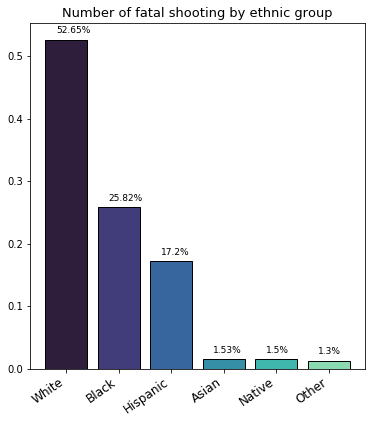

In [178]:
#Number of fatal shooting by ethnic group
df_vizrace=pd.DataFrame(df_viz_orig.race.value_counts(normalize=True))
x=np.arange(len(df_vizrace.index))

plt.bar(x, df_vizrace.race, color=sns.color_palette('mako', len(x)), edgecolor='black')
plt.xticks(x, df_vizrace.index, rotation=35,horizontalalignment='right', fontsize=12)
plt.title('Number of fatal shooting by ethnic group', fontsize=13)
for i in range(len(df_vizrace.race)):
    plt.text(x = i-0.2, y = df_vizrace.race[i]+0.01, s = (str(round(df_vizrace.race[i]*100,2))+'%'), size=9)
plt.subplots_adjust(bottom= 0.2, top = 1.4)
plt.show()

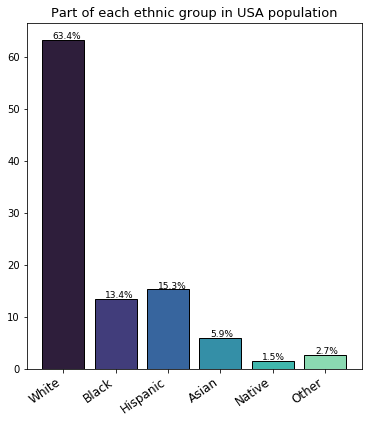

In [177]:
#part of each ethnic group in USA total population
x=np.arange(6)

data_pop=[63.4,13.4,15.3,5.9,1.5,2.7]
data_name=['White', 'Black', 'Hispanic', 'Asian', 'Native', 'Other']

plt.bar(x, data_pop, color=sns.color_palette('mako', len(x)), edgecolor='black')
plt.xticks(x, data_name, rotation=35,horizontalalignment='right', fontsize=12)
plt.title('Part of each ethnic group in USA population', fontsize=13)
for i in range(len(data_pop)):
    plt.text(x = i-0.2, y = data_pop[i]+0.15, s = (str(data_pop[i])+'%'), size=9)
plt.subplots_adjust(bottom= 0.2, top = 1.4)
plt.show()

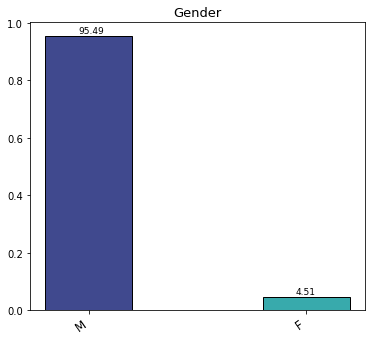

In [182]:
#visualisation by gender
df_vizgender=pd.DataFrame(df_viz_orig.gender.value_counts(normalize=True))
x=np.arange(len(df_vizgender.index))

plt.bar(x, df_vizgender.gender, color=sns.color_palette('mako', len(x)), edgecolor='black', width=0.4)
plt.xticks(x, df_vizgender.index, rotation=35,horizontalalignment='right', fontsize=12)
plt.title('Gender', fontsize=13)
for i in range(len(df_vizgender.gender)):
    plt.text(x = i-0.05, y = df_vizgender.gender[i]+0.01, s = round(df_vizgender.gender[i]*100,2), size = 9)
plt.subplots_adjust(bottom= 0.2, top = 1.2)
plt.show()

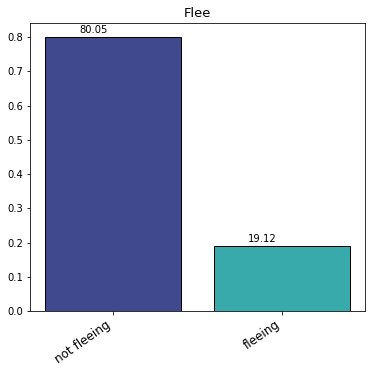

In [183]:
#visualisation by flee
df_vizflee=pd.DataFrame(df_viz_orig.flee.value_counts(normalize=True))
df_vizflee=df_vizflee.drop('unknown')
df_vizflee.index=['not fleeing','fleeing']
x=np.arange(len(df_vizflee.index))
plt.bar(x, df_vizflee.flee, color=sns.color_palette('mako', len(x)),edgecolor='black')
plt.xticks(x, df_vizflee.index, rotation=35,horizontalalignment='right', fontsize=12)
plt.title('Flee', fontsize=13)
for i in range(len(df_vizflee.flee)):
    plt.text(x = i-0.2, y = df_vizflee.flee[i]+0.01, s = round(df_vizflee.flee[i]*100,2))
plt.subplots_adjust(bottom= 0.2, top = 1.2)
plt.show()

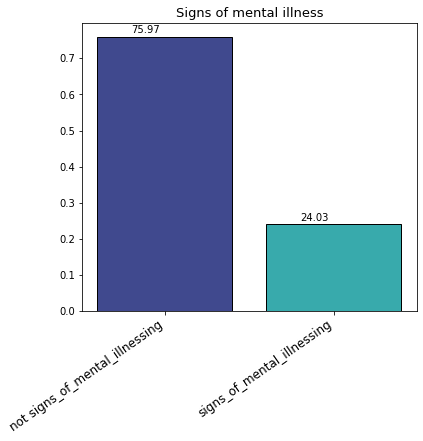

In [184]:
#visualisation by mental illness
df_vizmen=pd.DataFrame(df_viz_orig.signs_of_mental_illness.value_counts(normalize=True))
#df_vizmen=df_vizmen.signs_of_mental_illness.drop('unknown')
df_vizmen.index=['not signs_of_mental_illnessing','signs_of_mental_illnessing']
x=np.arange(len(df_vizmen.signs_of_mental_illness.index))
plt.bar(x, df_vizmen.signs_of_mental_illness, color=sns.color_palette('mako', len(x)),edgecolor='black')
plt.xticks(x, df_vizmen.signs_of_mental_illness.index, rotation=35,horizontalalignment='right', fontsize=12)
plt.title('Signs of mental illness', fontsize=13)
for i in range(len(df_vizmen.signs_of_mental_illness)):
    plt.text(x = i-0.2, y = df_vizmen.signs_of_mental_illness[i]+0.01, s = round(df_vizmen.signs_of_mental_illness[i]*100,2))
plt.subplots_adjust(bottom= 0.2, top = 1.2)
plt.show()

C:\Users\auror\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


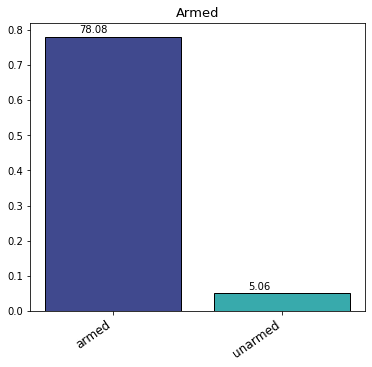

In [181]:
# visualisation armed or not
df_viz_orig.armed.unique()
kept_col=['unknown', 'unarmed']
df_viz_orig.armed=df_viz_orig.armed.map(lambda x: 'armed' if x not in kept_col else x)
dfviz_armed=pd.DataFrame(df_viz_orig.armed.value_counts(normalize=True))
dfviz_armed=pd.DataFrame(dfviz_armed.armed.drop('unknown'))
#dfviz_armed.index=['not armeding','armeding']
x=np.arange(len(dfviz_armed.index))
plt.bar(x, dfviz_armed.armed, color=sns.color_palette('mako', len(x)),edgecolor='black')
plt.xticks(x, dfviz_armed.armed.index, rotation=35,horizontalalignment='right', fontsize=12)
plt.title('Armed', fontsize=13)
for i in range(len(dfviz_armed.armed)):
    plt.text(x = i-0.2, y = dfviz_armed.armed[i]+0.01, s = round(dfviz_armed.armed[i]*100,2))
plt.subplots_adjust(bottom= 0.2, top = 1.2)
plt.show()

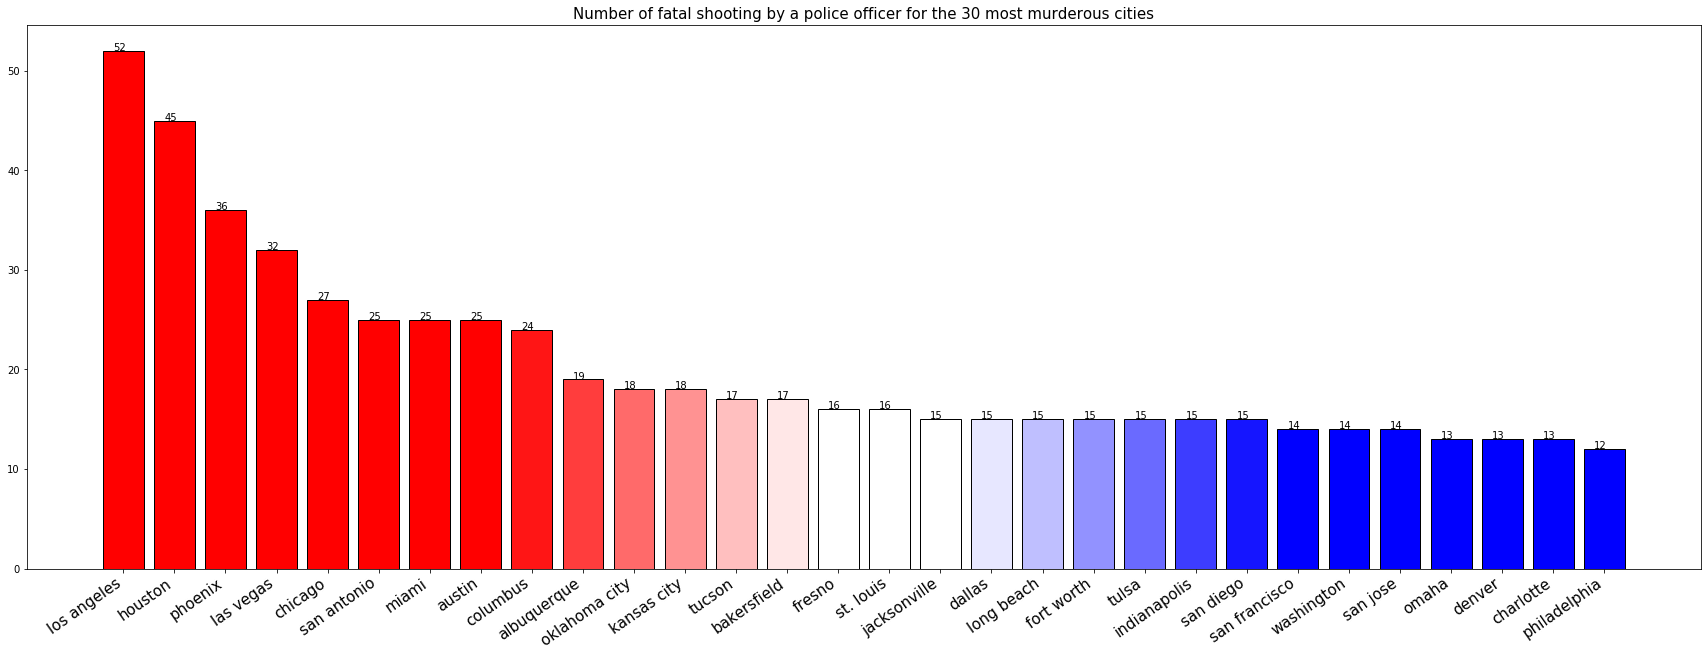

In [180]:
#visualisation by city
df_viz_cityo=pd.DataFrame(df_viz_orig.groupby(['city']).size())
df_viz_cityo.columns=['number']
df_viz_cityo=df_viz_cityo.sort_values(by='number', ascending=False)
df_viz_city=df_viz_cityo.head(30)
import matplotlib.colors as mcolors
x=np.arange(len(df_viz_city.index))
clist = [(0, "red"), (0.25, "red"), (0.45, "white"), (0.5, "white"), 
         (0.55, "white"), (0.75, "blue"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)
plt.figure(figsize=(30,10))
plt.bar(x, df_viz_city.number, color=rvb(x/30), edgecolor='black')
plt.xticks(x, df_viz_city.index, rotation=35,horizontalalignment='right', fontsize=15)
plt.title('Number of fatal shooting by a police officer for the 30 most murderous cities', fontsize=15)
for i in range(len(df_viz_city.number)):
    plt.text(x = i-0.2, y = df_viz_city.number[i]+0.01, s = df_viz_city.number[i])

plt.show()

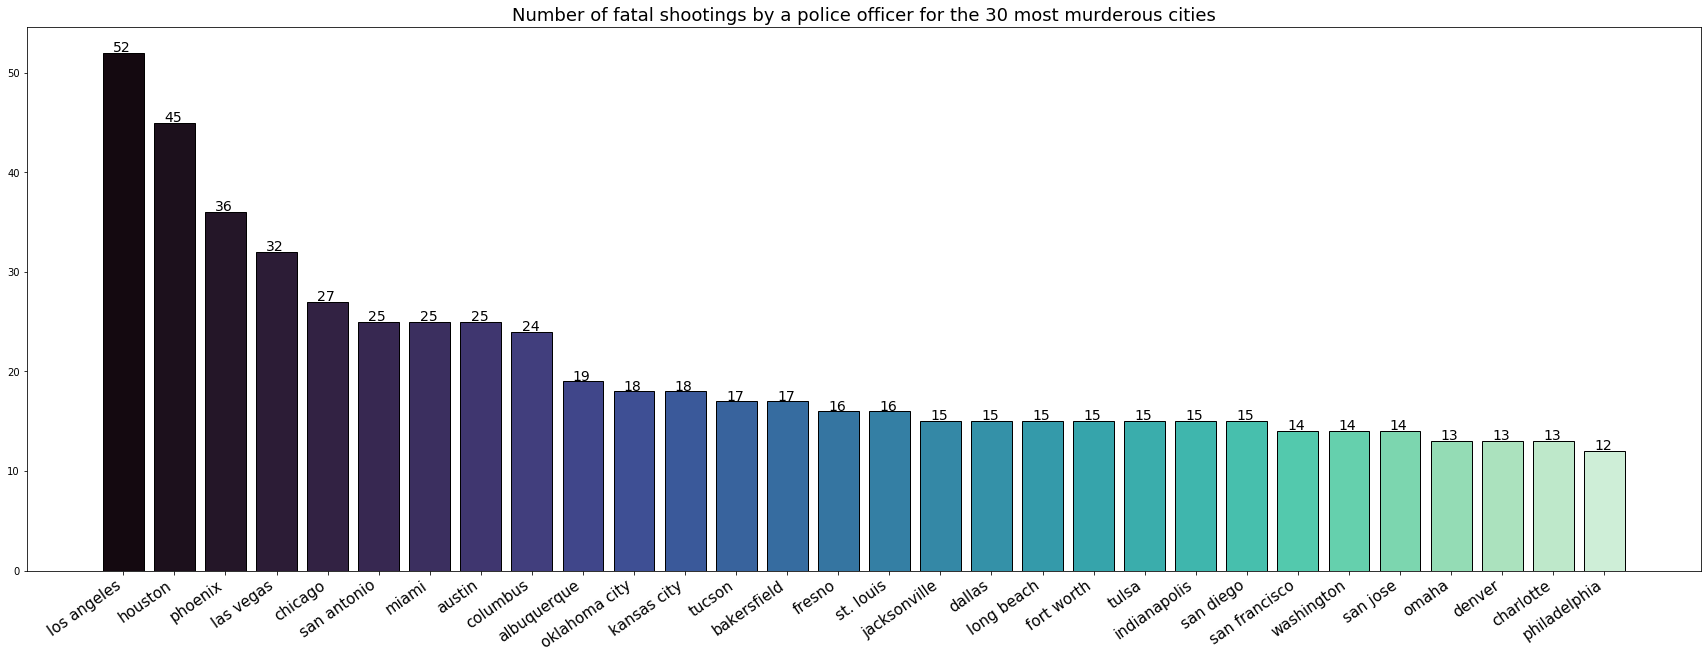

In [179]:
#visualisation by city
x=np.arange(len(df_viz_city.index))
plt.figure(figsize=(30,10))
plt.bar(x, df_viz_city.number, color=sns.color_palette('mako', len(x)), edgecolor='black')
plt.xticks(x, df_viz_city.index, rotation=35,horizontalalignment='right', fontsize=15)
plt.title('Number of fatal shootings by a police officer for the 30 most murderous cities', fontsize=18)
for i in range(len(df_viz_city.number)):
    plt.text(x = i-0.2, y = df_viz_city.number[i]+0.1, s = df_viz_city.number[i], fontsize=14)

plt.show()

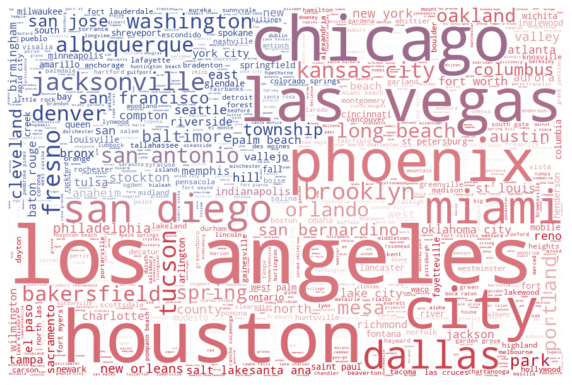

In [54]:
#word map USA
# Start with one review:
usa = " ".join(city for city in df.city)
mask = np.array(Image.open("C:/Users/auror/Final_Project/doc/us.PNG"))
wordcloud_usa = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(usa)
image_colors = ImageColorGenerator(mask)
# create coloring from image
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
# store to file
plt.savefig("doc/us.png", format="png")
plt.show()

In [87]:
df_city.columns=['state', 'city', 'Median Income', 'poverty_rate',
       'percent_completed_hs', 'share_white', 'share_black',
       'share_native_american', 'share_asian', 'share_hispanic', 'state_name',
       'pop_total_state', 'population', 'nb_period0', 'nb_period1',
       'nb_period2', 'nb_period3', 'nb_period4', 'total_FatalShooting']

In [88]:
#Data to send to tableau to viz
df_map=df_city.copy()
df_map["pop_total_state"]=df_map["pop_total_state"].str.replace(',','')
df_map["pop_total_state"] = pd.to_numeric(df_map["pop_total_state"])
#transform columns into numeric+ fillna 'Median Income' by the median of the state
df_map = df_map.drop(df_map[df_map['Median Income']=='-'].index).reset_index(drop=True)
df_map[df_map['Median Income']=='(X)']
df_map['Median Income']=df_map['Median Income'].str.replace('\(X\)','').str.replace('+','').str.replace(',','').str.replace('-','')
df_map[["share_hispanic",'share_asian','share_native_american','share_black','share_white','percent_completed_hs','poverty_rate', 'Median Income']] = df_map[["share_hispanic",'share_asian','share_native_american','share_black','share_white','percent_completed_hs','poverty_rate', 'Median Income']].apply(pd.to_numeric)
df_map['Median Income']= df_map[['state','Median Income']].groupby("state").transform(lambda x: x.fillna(x.median()))
#df_map.drop(['state','city', 'state_total_FatalShooting'], axis=1, inplace=True)

df_map1=df_map.pivot_table(index=['state'] , values=['Median Income', 'poverty_rate',
       'percent_completed_hs', 'share_white', 'share_black',
       'share_native_american', 'share_asian', 'share_hispanic', 'pop_total_state'], aggfunc='mean')
df_map2=df_map.pivot_table(index=['state'] , values=['total_FatalShooting'], aggfunc='sum')

df_map=pd.merge(df_map1,df_map2, on='state')
df_map=round(df_map,2)
df_map['Number of fatal shooting per 10000']=round(df_map['total_FatalShooting']/df_map['pop_total_state']*10000,2)
df_map.to_excel('df_map.xlsx', index=True)

# Correlation

In [94]:
#first the dataframe should be modified
dfm=df_city.copy()
dfm.drop('total_FatalShooting', axis=1, inplace=True)
dfm.columns=['state', 'city', 'Median Income', 'poverty_rate',
       'percent_completed_hs', 'share_white', 'share_black',
       'share_native_american', 'share_asian', 'share_hispanic', 'state_name',
       'pop_total_state', 'population', 'nb_period0', 'nb_period1',
       'nb_period2', 'nb_period3', 'y']
dfm["pop_total_state"]=dfm["pop_total_state"].str.replace(',','')
dfm["pop_total_state"] = pd.to_numeric(dfm["pop_total_state"])
dummies=[]
dummies.append('state_name')
#transform columns into numeric+ fillna 'Median Income' by the median of the state
dfm = dfm.drop(dfm[dfm['Median Income']=='-'].index).reset_index(drop=True)
dfm[dfm['Median Income']=='(X)']
dfm['Median Income']=dfm['Median Income'].str.replace('\(X\)','').str.replace('+','').str.replace(',','').str.replace('-','')
dfm[["share_hispanic",'share_asian','share_native_american','share_black','share_white','percent_completed_hs','poverty_rate', 'Median Income']] = dfm[["share_hispanic",'share_asian','share_native_american','share_black','share_white','percent_completed_hs','poverty_rate', 'Median Income']].apply(pd.to_numeric)
dfm['Median Income']= dfm[['state','Median Income']].groupby("state").transform(lambda x: x.fillna(x.median()))
dfm.drop(['state','city', 'state_name'], axis=1, inplace=True)

In [96]:
dfm_temp=dfm.copy()
dfm_temp.columns=['Median Income', 'poverty_rate', 'percent_completed_hs', 'share_white',
       'share_black', 'share_native_american', 'share_asian', 'share_hispanic',
       'pop_total_state', 'population', 'nb_period0', 'nb_period1',
       'nb_period2', 'nb_period3', 'nb_period4']

In [89]:
#check on the correlation

def corr_f(df, figsize=(8,6),i=0.7):
    plt.subplots(figsize=figsize)
    ax = sns.heatmap(
        df.corr(), 
        cmap='BrBG', annot=False)

    ax.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=12);

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=35,
        horizontalalignment='right', fontsize=10);

    ax.set_yticklabels(
        ax.get_xticklabels(), fontsize=10);

    corr_matrix = df.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    col_hightly_correlated=[]

    for column in range(len(upper.columns)):
        for ind in range(len(upper.index)):
            if (upper.iloc[ind,column] > i) | (upper.iloc[ind,column] < -i):
                col_hightly_correlated.append([upper.index[ind], upper.index[column],round(upper.iloc[ind,column],2)])

    return col_hightly_correlated


[['share_white', 'share_black', -0.82],
 ['nb_period0', 'nb_period1', 0.85],
 ['nb_period0', 'nb_period2', 0.87],
 ['nb_period1', 'nb_period2', 0.86],
 ['nb_period0', 'nb_period3', 0.81],
 ['nb_period1', 'nb_period3', 0.79],
 ['nb_period2', 'nb_period3', 0.85],
 ['nb_period0', 'nb_period4', 0.77],
 ['nb_period1', 'nb_period4', 0.74],
 ['nb_period2', 'nb_period4', 0.82],
 ['nb_period3', 'nb_period4', 0.84]]

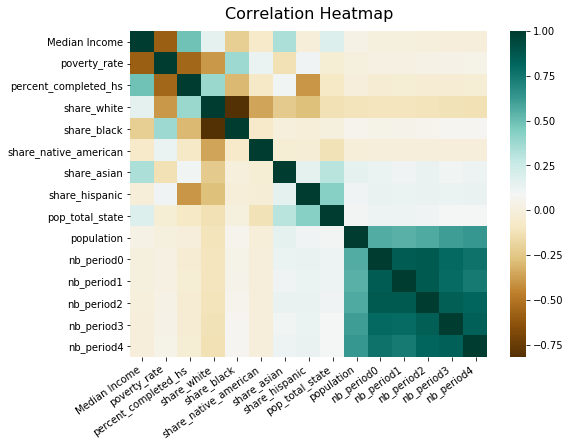

In [97]:
corr_f(dfm_temp)

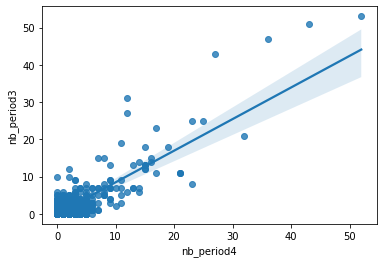

In [105]:
sns.regplot(dfm_temp.nb_period4, dfm_temp.nb_period3)

Text(0.5, 1.0, 'Education / Fatal Shootings by cities')

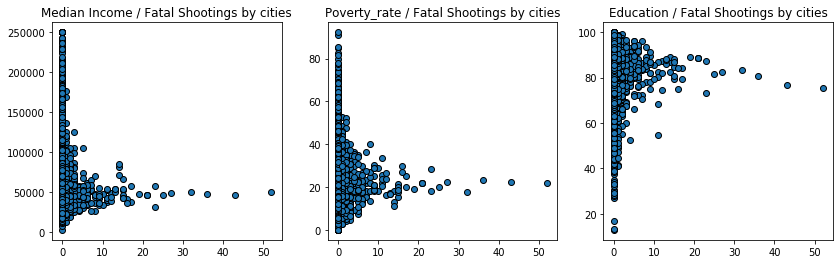

In [51]:
fig, axes=plt.subplots(1,3, figsize=(14,4))
axes[0].scatter(dfm['y'], dfm['Median Income'], marker = 'o', edgecolors = 'black')
axes[0].set_title('Median Income / Fatal Shootings by cities')
axes[1].scatter(dfm['y'], dfm['poverty_rate'], marker = 'o', edgecolors = 'black')
axes[1].set_title('Poverty_rate / Fatal Shootings by cities')
axes[2].scatter(dfm['y'], dfm['percent_completed_hs'], marker = 'o', edgecolors = 'black')
axes[2].set_title('Education / Fatal Shootings by cities')

The number of fatal shootings between 2015 & 2017 is highly correlated to the other period, and more especially between 2012 & 2014. So let's check the linear regression.

# Modeling

## 1. Linear Regression between period 2015/17 & period 2012/2014

In [103]:
modeleReg=LinearRegression()
y=dfm.y
X=dfm.drop('y', axis=1)
modeleReg.fit(X,y)

LinearRegression()

In [112]:
from statsmodels.formula.api import ols
model=ols('y ~ nb_period3', data=dfm)
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                 4.737e+04
Date:                Tue, 10 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:58:27   Log-Likelihood:                -16617.
No. Observations:               19639   AIC:                         3.324e+04
Df Residuals:                   19637   BIC:                         3.325e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0379      0.004      9.364      0.000       0.030       0.046
nb_period3     0.8336      0.004    217.648      0.000       0.826       0.841
==============================================================================
Omnibus:                    22637.964   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20710837.613
Skew:                           5.231   Prob(JB):                         0.00
Kurtosis:                     161.746   Cond. No.                         1.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### __We get here a strong correlation (R-squared > 0.7). The best way to predict fatal shootings for the next 3 years is to check the last 3 years.__

## 2. Tweedie Regression

C:\Users\auror\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


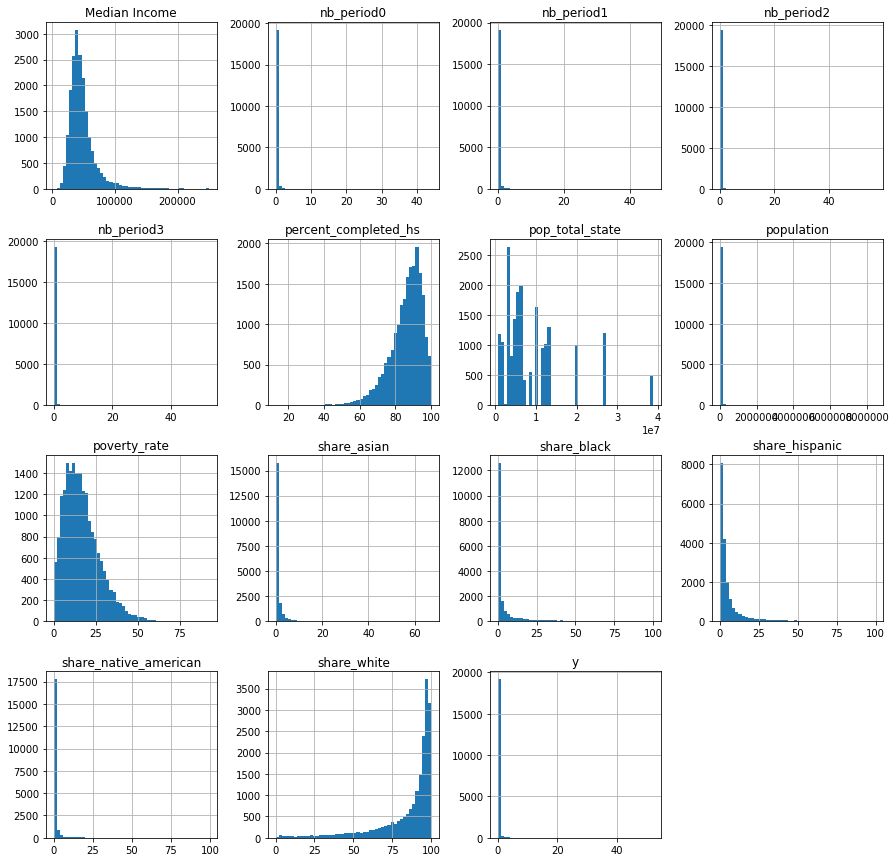

In [55]:
fig, ax = plt.subplots(figsize = (15,15))
dfm.hist(ax = ax, bins=50)
plt.show()

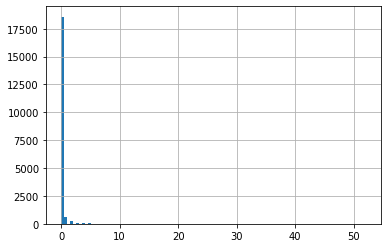

In [56]:
dfm.y.hist(bins=100)

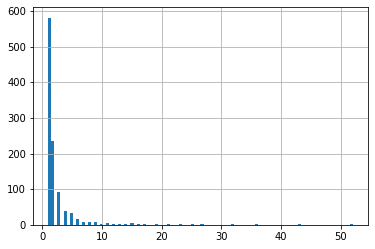

In [57]:
dfm_temp=dfm.drop(dfm[dfm.y==0].index).reset_index(drop=True)
dfm_temp.y.hist(bins=100)

The distribution is not normal with a huge pic at '0', so the best model seems to be here Tweedie Regressor

In [114]:
#function score
def score_estimator(
    estimator, X_train, X_test, df_train, df_test, target, weights,
    tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),   # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [(
            "mean Tweedie dev p={:.4f}".format(power),
            partial(mean_tweedie_deviance, power=power)
        ) for power in tweedie_powers]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append(
                {"subset": subset_label, "metric": score_label, "score": score}
            )

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ['train', 'test']]
    )
    return res

In [164]:
#function tweedie
dfm1=dfm.copy()
drop_col=['nb_period0', 'nb_period1','nb_period2', 'nb_period3']
dfm1.drop(drop_col, axis=1, inplace=True)
dfm1=dfm1.applymap(lambda x : 0.0001 if x ==0 else x)
col_t=['Median Income', 'poverty_rate', 'percent_completed_hs', 'share_white',
           'share_black', 'share_native_american', 'share_asian', 'share_hispanic',
           'pop_total_state', 'population']

def f_tweedie(dfm1, col_t):
    log_scale_transformer = make_pipeline(
        FunctionTransformer(func=np.log),
        StandardScaler()
    )
    
    column_trans = ColumnTransformer(
        [
            ("log_scaled_numeric", log_scale_transformer, col_t),
        ],
    )
    X = column_trans.fit_transform(dfm1)
    df_train, df_test, X_train, X_test = train_test_split(dfm1, X, random_state=0)

    glm_pure_premium = TweedieRegressor(power=1.9, alpha=.1, max_iter=10000)
    glm_pure_premium.fit(X_train, df_train['y'], sample_weight=df_train["y"])

    tweedie_powers = [1.3,1.5, 1.8, 1.9, 2,2.1, 2.2, 2.22, 2.5, 3]

    scores_glm_pure_premium = score_estimator(
        glm_pure_premium,
        X_train,
        X_test,
        df_train,
        df_test,
        target="y",
        weights="y",
        tweedie_powers=tweedie_powers
    )
    return scores_glm_pure_premium

In [165]:
f_tweedie(dfm1, col_t)

subset,train,test
metric,,
D² explained,0.4966,-0.2237
mean Tweedie dev p=1.3000,2.4774,3.4891
mean Tweedie dev p=1.5000,1.6477,2.6495
mean Tweedie dev p=1.8000,0.9726,2.0093
mean Tweedie dev p=1.9000,0.8383,1.9063
mean Tweedie dev p=2.0000,0.7348,1.8454
mean Tweedie dev p=2.1000,0.6575,1.8228
mean Tweedie dev p=2.2000,0.6043,1.8378
mean Tweedie dev p=2.2200,0.5966,1.8454


In [159]:
#DummyRegressor only to compare with the results of tweedie
log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log),
    StandardScaler()
)

column_trans = ColumnTransformer(
    [
        ("log_scaled_numeric", log_scale_transformer, col_t),
    ],
)
X = column_trans.fit_transform(dfm1)
df_train, df_test, X_train, X_test = train_test_split(dfm1, X, random_state=0)

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, df_train['y'])
scores_dummy_regr=score_estimator(
    dummy_regr,
    X_train,
    X_test,
    df_train,
    df_test,
    target="y",
    weights="y"
)
scores_dummy_regr

subset,train,test
metric,,
D² explained,-0.5407,-0.6426
mean abs. error,8.2781,7.5482
mean squared error,195.2634,145.6299


In [161]:
#test with feature selection 
for k in range(2,9):
    estimator=TweedieRegressor()
    sfs1=sfs(estimator, 
             k_features=k,
             forward=True,
             floating=False,
             scoring='neg_mean_squared_error', #default - R2
            )

    sfs1.fit(X_train, df_train['y'])
    sfs1.get_metric_dict()
    l=[int(i) for i in list(sfs1.k_feature_names_)]
    dfm_temp=dfm.iloc[:,l]
    print('For k=',k, 'the features selected are :', dfm_temp.columns)

For k= 2 the features selected are : Index(['share_white', 'population'], dtype='object')
For k= 3 the features selected are : Index(['percent_completed_hs', 'share_white', 'population'], dtype='object')
For k= 4 the features selected are : Index(['Median Income', 'percent_completed_hs', 'share_white', 'population'], dtype='object')
For k= 5 the features selected are : Index(['Median Income', 'poverty_rate', 'percent_completed_hs', 'share_white',
       'population'],
      dtype='object')
For k= 6 the features selected are : Index(['Median Income', 'poverty_rate', 'percent_completed_hs', 'share_white',
       'share_native_american', 'population'],
      dtype='object')
For k= 7 the features selected are : Index(['Median Income', 'poverty_rate', 'percent_completed_hs', 'share_white',
       'share_native_american', 'pop_total_state', 'population'],
      dtype='object')
For k= 8 the features selected are : Index(['Median Income', 'poverty_rate', 'percent_completed_hs', 'share_white',


In [148]:
dfm1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19639 entries, 0 to 19638
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Median Income          19639 non-null  float64
 1   poverty_rate           19639 non-null  float64
 2   percent_completed_hs   19639 non-null  float64
 3   share_white            19639 non-null  float64
 4   share_black            19639 non-null  float64
 5   share_native_american  19639 non-null  float64
 6   share_asian            19639 non-null  float64
 7   share_hispanic         19639 non-null  float64
 8   pop_total_state        19639 non-null  int64  
 9   population             19639 non-null  float64
 10  y                      19639 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 1.6 MB


In [155]:
dfm2=dfm1.iloc[:,[0, 1, 2, 3, 5, 10]]
col_t2=['Median Income', 'poverty_rate', 'percent_completed_hs', 'share_white', 'share_native_american']

In [156]:
f_tweedie(dfm2, col_t2)

subset,train,test
metric,,
D² explained,0.1833,0.1052
mean Tweedie dev p=1.3000,4.6902,4.5944
mean Tweedie dev p=1.5000,3.0285,3.0203
mean Tweedie dev p=1.8000,1.6448,1.6760
mean Tweedie dev p=1.9000,1.3599,1.3940
mean Tweedie dev p=2.0000,1.1334,1.1682
mean Tweedie dev p=2.3000,0.7160,0.7497
mean Tweedie dev p=2.3100,0.7082,0.7420
mean Tweedie dev p=2.3200,0.7009,0.7347


#### __Even with feature selection, the metrics with Tweedie Regression are not good. The better way to predict is still to have a look on the past.__ 